In [1]:
from pathlib import Path
from collections import namedtuple
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats as stats
from sklearn.linear_model import Perceptron
import sliding1d as sliding

import datareader as dr
import saccades as sc
import trial_envelope as envelope
from kw_dunn import kw_dunn

In [2]:
trials  = dr.load_trials("../01_data/04_formatted")

# representative session
subject = "MLA007518"
session = "session2019-09-30-001"

in_session = [trial for trial in trials if (trial.subject == subject and trial.session == session)]

In [3]:
figroot = Path("../05_figures/prediction/perceptrons")
saved   = False

labelsize = 12

def savefig(fig, basepath, root=None, dpi=600, as_png=True, as_svg=True):
    if saved == False:
        return
    if root is None:
        root = figroot
    base = root / Path(basepath)
    if not base.parent.exists():
        base.parent.mkdir(parents=True)
    is_saved = False
    if as_png == True:
        fig.savefig(str(base) + ".png", dpi=dpi)
        is_saved = True
    if as_svg == True:
        fig.savefig(str(base) + ".svg")
        is_saved = True
    if saved == True:
        print(f"--> saved to: {base}")
    else:
        print(f"--> ***not saved: {base}")

def psign(p, append=True):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ", NS" if append else "NS"

## Single session: collecting data for prediction

In [4]:
def baseline(vec, timerange):
    return np.nanmedian(vec[timerange])

def get_weights(vec):
    return np.ones(vec.size) / vec.size

def in_camel(txt):
    return txt[0].upper() + txt[1:]

class TimeRange(namedtuple("_TimeRange", ("fromFrame", "toFrame"))):
    @classmethod
    def from_range(cls, timerange):
        return cls(*[int(v) for v in timerange])
    
    @classmethod
    def from_row(cls, trial_row):
        return cls(int(trial_row.FromFrame), int(trial_row.ToFrame))
    
    def as_slice(self):
        return slice(self.fromFrame - 1, self.toFrame)

def time_normalized(vec, num=100):
    size     = vec.size
    origtime = np.linspace(0, 1, size, endpoint=True)
    desttime = np.linspace(0, 1, num, endpoint=True)
    return np.interp(desttime, origtime, vec)

def before_start(trial):
    """return the time range tuple corresponding to the initial AtEnd phase."""
    return TimeRange.from_row(trial.states[trial.states.State == "AtEnd"].iloc[0])

def count_epochs(trial,
                 pattern="AtEnd <Backward> Left",
                 **kwargs):
    return [[1] for rng in trial.get_timeranges(pattern)]

def setpoint_asymmetry_from_trial(trial,
                                  pattern="AtEnd <Backward> Left",
                                  radius_sample=10):
    ranges = [TimeRange.from_range(rng) for rng in trial.get_timeranges(pattern)]
    if len(ranges) == 0:
        return []
    else:
        sides      = ("left", "right")
        envelopes  = dict((side, envelope.whisker(trial, side=side, radius_sample=radius_sample)) \
                          for side in sides)
        base_range = before_start(trial)
        baselines  = dict((side, baseline(envelopes[side].raw, base_range.as_slice())) \
                         for side in sides)
        subtracted = dict((side, envelopes[side].bottom - baselines[side]) \
                         for side in sides)
        asymmetry  = subtracted["right"] - subtracted["left"]
        return [asymmetry[rng.as_slice()] for rng in ranges]

def eye_position_from_trial(trial,
                            pattern="AtEnd <Backward> Left",
                            radius_sample=10):
    ranges = [TimeRange.from_range(rng) for rng in trial.get_timeranges(pattern)]
    if len(ranges) == 0:
        return []
    else:
        sides = ("left", "right")
        raw   = dict((side, envelope.interpolate(trial.tracking[f"{side}_pupil_normalized_position"])) \
                          for side in sides)
        if all(np.isnan(raw["left"])):
            return []
        smo   = dict((side, sliding.nanmean(raw[side], rad=radius_sample)) \
                     for side in sides)
        avg   = (smo["left"] + smo["right"]) / 2
        return [avg[rng.as_slice()] for rng in ranges]

def bin_trace(trace, nbin=5, reduce=None):
    """bin single-trial traces based on time, and return the list of split traces."""
    if reduce is None:
        reduce = lambda trace: trace
    t = np.linspace(0, 1, num=trace.size, endpoint=False)
    borders = np.linspace(0, 1, num=nbin+1, endpoint=True)
    return [reduce(trace[np.logical_and(t>=start, t<stop)]) for start, stop in zip(borders[:-1], borders[1:])]

class NoEpochFoundError(ValueError):
    def __init__(self, msg):
        super().__init__(msg)

def collect_binned(trials, fun, nbin=5, reduce=None, merge=None, **kwargs):
    epochs = sum([fun(trial, **kwargs) for trial in trials], [])
    if len(epochs) == 0:
        raise NoEpochFoundError(f"no epoch found from {len(trials)} trials ({fun.__name__}, {kwargs.get('pattern', '(no pattern info)')})")
    # print((f"{len(epochs)} epochs found from {len(trials)} trials ({fun.__name__}, {kwargs.get('pattern', '(no pattern info)')})"))
    ret = []
    for ibin in range(nbin):
        ret.append([])
    for epoch in epochs:
        for ibin, binned in enumerate(bin_trace(epoch, nbin=nbin, reduce=reduce)):
            ret[ibin].append(binned)
    if merge is not None:
        for ibin in range(nbin):
            ret[ibin] = merge(ret[ibin])
    return ret

def compute_binned_points(trials, base_pattern="AtEnd <Backward> {direction}", nbin=5):
    binned = dict()
    for key in ('whisker', 'eye'):
        binned[key] = []
        for ibin in range(nbin):
            binned[key].append({})

    for direction in ("Left", "Right"):
        pattern = base_pattern.format(direction=direction)
        for ibin, vals in enumerate(collect_binned(trials,
                                                   setpoint_asymmetry_from_trial,
                                                   pattern=pattern,
                                                   merge=np.concatenate)):
            binned['whisker'][ibin][direction.lower()] = vals
        
        for ibin, vals in enumerate(collect_binned(trials,
                                                  eye_position_from_trial,
                                                  pattern=pattern,
                                                  merge=np.concatenate)):

            binned["eye"][ibin][direction.lower()] = vals
    
    return binned

def colored_hist2d(bin_whisker, bin_eye, nbin=10,
                 range_whisker=(-1, 1), range_eye=(-0.2, 0.2),
                 cmap=dict(left='bwr', right='bwr_r')):
    H = {}
    for direction in ('left', 'right'):
        h, xedges, yedges = np.histogram2d(bin_whisker[direction],
                                           bin_eye[direction],
                                           bins=nbin,
                                           range=(range_whisker, range_eye))
        H[direction] = plt.get_cmap(cmap[direction])(h / h.max()*2 + 0.5)
    H = (H['left'] + H['right'])/2
    return H, xedges, yedges

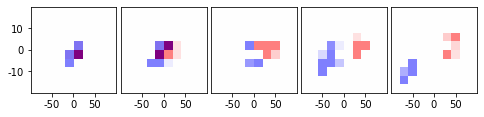

In [5]:
binned = compute_binned_points(in_session)

fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(8, 2))
for ibin, ax in enumerate(axes):
    H, xedges, yedges = colored_hist2d(binned['whisker'][ibin], binned['eye'][ibin])
    ax.imshow(H.transpose((1,0,2)), aspect=5, origin='lower', extent=(xedges.min(), xedges.max(), yedges.min(), yedges.max()))
    ax.tick_params(left=(ibin == 0), labelsize=10)
plt.xticks((-0.5, 0, 0.5), ("-50", "0", "50"))
plt.yticks((-0.1, 0, 0.1), ("-10", "0", "10"))
plt.subplots_adjust(wspace=.05)
savefig(fig, f"2d-hist-representative")
plt.show()

In [6]:
# color bar, left
grad = np.linspace(0, 1, 100).reshape((-1,1))
null = np.zeros((100, 1))
img  = (plt.get_cmap('bwr')(grad/2 + 0.5) + plt.get_cmap('bwr_r')(null/2 + 0.5))/2
fig  = plt.figure(figsize=(0.5, 2))
plt.imshow(img, aspect=.08, origin='lower')
plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.subplots_adjust(bottom=.05, top=.95, left=.05, right=.95)
savefig(fig, f"2d-hist-representative_cb-left")
plt.show()

In [7]:
# color bar, right
grad = np.linspace(0, 1, 100).reshape((-1,1))
null = np.zeros((100, 1))
img  = (plt.get_cmap('bwr_r')(grad/2 + 0.5) + plt.get_cmap('bwr')(null/2 + 0.5))/2
fig  = plt.figure(figsize=(0.5, 2))
plt.imshow(img, aspect=.08, origin='lower')
plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.subplots_adjust(bottom=.05, top=.95, left=.05, right=.95)
savefig(fig, f"2d-hist-representative_cb-right")
plt.show()

## Multiple sessions: fidelity testing

In [8]:
def create_design_matrix(bin_whisker, bin_eye, shuffle_whisker=False, shuffle_eye=False, random_state=539167):
    
    def _shuffled(x):
        np.random.seed(random_state)
        x = x.copy()
        np.random.shuffle(x)
        return x
        
    x_whisker = np.concatenate([bin_whisker['left'], bin_whisker['right']])
    x_eye     = np.concatenate([bin_eye['left'], bin_whisker['right']])
    
    if shuffle_whisker == True:
        x_whisker = _shuffled(x_whisker)
    if shuffle_eye == True:
        x_eye = _shuffled(x_eye)
    
    X = np.stack([x_whisker, x_eye], axis=-1)
    y = np.concatenate([np.ones(bin_whisker['left'].size, dtype=bool),
                        np.zeros(bin_whisker['right'].size, dtype=bool)])
    return X, y

def perceptron_fidelity(X, y, random_state=539167):
    y_hat  = Perceptron(random_state=random_state).fit(X, y).predict(X)
    return np.count_nonzero(y == y_hat) / y.size

def binned_fidelity_for_session(trials, nbin=5, random_state=539167):
    points_binned = compute_binned_points(trials, nbin=nbin)

    raw_fidelity = {}
    for shuffle_whisker in (False, True):
        for shuffle_eye in (False, True):
            binned = []
            for ibin in range(nbin):
                X, y = create_design_matrix(points_binned['whisker'][ibin], points_binned['eye'][ibin],
                                            shuffle_whisker=shuffle_whisker, shuffle_eye=shuffle_eye,
                                            random_state=random_state)
                binned.append(perceptron_fidelity(X, y, random_state=random_state))
            raw_fidelity[shuffle_whisker, shuffle_eye] = np.array(binned)

    fidelity = {
        'full': raw_fidelity[False, False],
        'null': raw_fidelity[True, True],
        'whisker_unique': raw_fidelity[False, False] - raw_fidelity[True, False],
        'eye_unique':     raw_fidelity[False, False] - raw_fidelity[False, True],
    }
    return fidelity

In [9]:
nbin = 5
data = []
for subject, session in set((trial.subject, trial.session) for trial in trials):
    try:
        in_session = [trial for trial in trials if (trial.subject == subject and trial.session == session)]
        data.append(binned_fidelity_for_session(in_session, nbin=nbin))
    except NoEpochFoundError as e:
        print(f"***in {subject}, {session}: {e}")

data = dict((key, np.stack([item[key] for item in data], axis=-1)) for key in ('full', 'null', 'whisker_unique', 'eye_unique'))

***in MLA007518, session2019-10-04-001: no epoch found from 5 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA005757, session2019-07-18-001: no epoch found from 5 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA007519, session2019-10-01-001: no epoch found from 5 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA007518, session2019-10-07-001: no epoch found from 4 trials (setpoint_asymmetry_from_trial, AtEnd <Backward> Right)
***in MLA007519, session2019-09-30-001: no epoch found from 3 trials (setpoint_asymmetry_from_trial, AtEnd <Backward> Right)
***in MLA007519, session2019-10-02-001: no epoch found from 4 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA007519, session2019-09-29-001: no epoch found from 3 trials (eye_position_from_trial, AtEnd <Backward> Left)
***in MLA005757, session2019-07-16-001: no epoch found from 5 trials (setpoint_asymmetry_from_trial, AtEnd <Backward> Right)


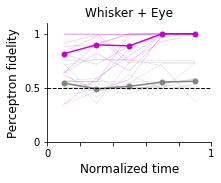

In [10]:
x = np.arange(nbin)*0.2 + 0.1
xticks = (0, 0.2, 0.4, 0.6, 0.8, 1)
xticklabels = ("0", "", "", "", "", "1")
marker = 12

fig = plt.figure(figsize=(3, 2.5))
plt.plot(x, data['full'], "-", color='m', lw=.5, alpha=.3)
plt.plot(x, np.median(data['full'], -1), ".-", color='m', lw=1.5, alpha=.95, 
         ms=marker, mec='none')
plt.plot(x, data['null'], "-", color="gray", lw=.5, alpha=.3)
plt.plot(x, np.median(data['null'],-1), ".-", color="gray", lw=1.5, alpha=.95, 
         ms=marker, mec='none')
plt.hlines(0.5, 0, 1, color="k", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.xticks(xticks, xticklabels)
plt.yticks((0, 0.5, 1), ("0", "0.5", "1"))
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.xlabel("Normalized time", fontsize=labelsize)
plt.ylabel("Perceptron fidelity", fontsize=labelsize)
plt.title("Whisker + Eye", fontsize=labelsize)
plt.subplots_adjust(left=.22, right=.98, bottom=.22)
savefig(fig, f"fidelity-fullnull-allsessions")
plt.show()

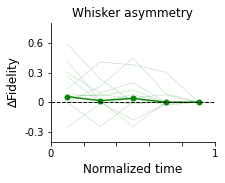

In [11]:
x = np.arange(nbin)*0.2 + 0.1
xticks = (0, 0.2, 0.4, 0.6, 0.8, 1)
xticklabels = ("0", "", "", "", "", "1")
marker = 12

fig = plt.figure(figsize=(3, 2.5))
plt.plot(x, data['whisker_unique'], "-", color='g', lw=.5, alpha=.3)
plt.plot(x, np.median(data['whisker_unique'], -1), ".-", color='g', lw=1.5, alpha=.95, 
         ms=marker, mec='none')
# plt.plot(x, data['eye_unique'], "-", color="firebrick", lw=.5, alpha=.3)
# plt.plot(x, np.median(data['eye_unique'],-1), ".-", color="firebrick", lw=1.5, alpha=.95, 
#          ms=marker, mec='none')
plt.hlines(0, 0, 1, color="k", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.ylim(-0.4, 0.8)
plt.xticks(xticks, xticklabels)
plt.yticks((-0.3, 0, 0.3, 0.6), ("-0.3", "0", "0.3", "0.6"))
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.xlabel("Normalized time", fontsize=labelsize)
plt.ylabel("∆Fidelity", fontsize=labelsize)
plt.title("Whisker asymmetry", fontsize=labelsize)
plt.subplots_adjust(left=.22, right=.98, bottom=.22)
savefig(fig, f"fidelity-whisker-unique-allsessions")
plt.show()

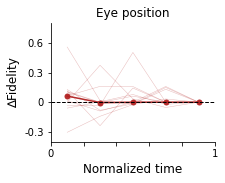

In [12]:
x = np.arange(nbin)*0.2 + 0.1
xticks = (0, 0.2, 0.4, 0.6, 0.8, 1)
xticklabels = ("0", "", "", "", "", "1")
marker = 12

fig = plt.figure(figsize=(3, 2.5))
# plt.plot(x, data['whisker_unique'], "-", color='g', lw=.5, alpha=.3)
# plt.plot(x, np.median(data['whisker_unique'], -1), ".-", color='g', lw=1.5, alpha=.95, 
#          ms=marker, mec='none')
plt.plot(x, data['eye_unique'], "-", color="firebrick", lw=.5, alpha=.3)
plt.plot(x, np.median(data['eye_unique'],-1), ".-", color="firebrick", lw=1.5, alpha=.95, 
         ms=marker, mec='none')
plt.hlines(0, 0, 1, color="k", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.ylim(-0.4, 0.8)
plt.xticks(xticks, xticklabels)
plt.yticks((-0.3, 0, 0.3, 0.6), ("-0.3", "0", "0.3", "0.6"))
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.xlabel("Normalized time", fontsize=labelsize)
plt.ylabel("∆Fidelity", fontsize=labelsize)
plt.title("Eye position", fontsize=labelsize)
plt.subplots_adjust(left=.22, right=.98, bottom=.22)
savefig(fig, f"fidelity-eye-unique-allsessions")
plt.show()

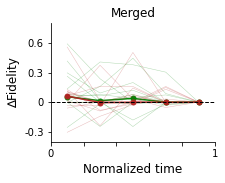

In [13]:
x = np.arange(nbin)*0.2 + 0.1
xticks = (0, 0.2, 0.4, 0.6, 0.8, 1)
xticklabels = ("0", "", "", "", "", "1")
marker = 12

fig = plt.figure(figsize=(3, 2.5))
plt.plot(x, data['whisker_unique'], "-", color='g', lw=.5, alpha=.3)
plt.plot(x, np.median(data['whisker_unique'], -1), ".-", color='g', lw=1.5, alpha=.95, 
         ms=marker, mec='none')
plt.plot(x, data['eye_unique'], "-", color="firebrick", lw=.5, alpha=.3)
plt.plot(x, np.median(data['eye_unique'],-1), ".-", color="firebrick", lw=1.5, alpha=.95, 
         ms=marker, mec='none')
plt.hlines(0, 0, 1, color="k", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.ylim(-0.4, 0.8)
plt.xticks(xticks, xticklabels)
plt.yticks((-0.3, 0, 0.3, 0.6), ("-0.3", "0", "0.3", "0.6"))
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.xlabel("Normalized time", fontsize=labelsize)
plt.ylabel("∆Fidelity", fontsize=labelsize)
plt.title("Merged", fontsize=labelsize)
plt.subplots_adjust(left=.22, right=.98, bottom=.22)
savefig(fig, f"fidelity-merged-unique-allsessions")
plt.show()

In [14]:
groups = [
    # full model
    data['full'][0],
    data['full'][1],
    data['full'][2],
    data['full'][3],
    data['full'][4],
    
    # null model
    data['null'][0],
    data['null'][1],
    data['null'][2],
    data['null'][3],
    data['null'][4],
    
    # non-whisker model
    data['full'][0] - data['whisker_unique'][0],
    data['full'][1] - data['whisker_unique'][1],
    data['full'][2] - data['whisker_unique'][2],
    data['full'][3] - data['whisker_unique'][3],
    data['full'][4] - data['whisker_unique'][4],
    
    # non-eye model
    data['full'][0] - data['eye_unique'][0],
    data['full'][1] - data['eye_unique'][1],
    data['full'][2] - data['eye_unique'][2],
    data['full'][3] - data['eye_unique'][3],
    data['full'][4] - data['eye_unique'][4],
]

pairs = [
    # full vs null
    (0, 5),
    (1, 6),
    (2, 7),
    (3, 8),
    (4, 9),
    
    # full vs non-whisker
    (0, 10),
    (1, 11),
    (2, 12),
    (3, 13),
    (4, 14),
    
    # full vs non-eye
    (0, 15),
    (1, 16),
    (2, 17),
    (3, 18),
    (4, 19),
]

In [15]:
results = kw_dunn(groups, pairs)

kwtab = {
    'Item1': ['(all)'],
    'Item2': ['(all)'],
    'P': [results.p_omnibus,],
    'Sign': [psign(results.p_omnibus, append=False)],
}

flag = ['Full', 'Null', 'Non-whisker', 'Non-eye']

for (item1, item2), dunn in results.pairwise.items():
    flag1 = flag[item1 // 5] + "-" + str(item1 % 5 + 1)
    flag2 = flag[item2 // 5] + "-" + str(item2 % 5 + 1)
    kwtab['Item1'].append(flag1)
    kwtab['Item2'].append(flag2)
    kwtab['P'].append(dunn.p_corrected)
    kwtab['Sign'].append(psign(dunn.p_corrected, append=False))

kwtab = pd.DataFrame(kwtab)
if saved == True:
    kwtab.to_csv(str(figroot / "KW-Dunn.csv"), header=True, index=False)
kwtab

Item1          Item2             P Sign
0    (all)          (all)  4.090074e-24  ***
1   Full-1         Null-1  3.673581e-01   NS
2   Full-2         Null-2  3.791739e-02    *
3   Full-3         Null-3  9.748826e-03   **
4   Full-4         Null-4  2.873942e-05  ***
5   Full-5         Null-5  4.411170e-06  ***
6   Full-1  Non-whisker-1  1.000000e+00   NS
7   Full-2  Non-whisker-2  1.000000e+00   NS
8   Full-3  Non-whisker-3  1.000000e+00   NS
9   Full-4  Non-whisker-4  1.000000e+00   NS
10  Full-5  Non-whisker-5  1.000000e+00   NS
11  Full-1      Non-eye-1  1.000000e+00   NS
12  Full-2      Non-eye-2  1.000000e+00   NS
13  Full-3      Non-eye-3  1.000000e+00   NS
14  Full-4      Non-eye-4  1.000000e+00   NS
15  Full-5      Non-eye-5  1.000000e+00   NS